In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import torch
import torch.nn as nn
import random
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

In [3]:
# fastai
import fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

In [4]:
seed = 80086

In [5]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

In [6]:
flight_data = sns.load_dataset("flights")
flight_data.head(20)

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121
5,1949,June,135
6,1949,July,148
7,1949,August,148
8,1949,September,136
9,1949,October,119


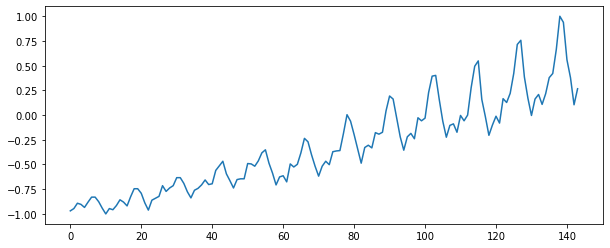

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
flight_data['passengers'] = scaler.fit_transform(flight_data['passengers'].values.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 4))
plt.plot(flight_data['passengers'])

In [8]:
def lag_with_pct_change(df, windows):
    train_cols = []
    for window in reversed(windows):    
        df['shift_pos_' + str(window)] = df['passengers'].shift(window).fillna(0)
        train_cols.append('shift_pos_' + str(window))
    return df[len(windows):], train_cols

In [9]:
df, train_cols = lag_with_pct_change(flight_data, range(1, 13))
df['group'] = df.groupby(df.index//6, sort=False)['passengers'].agg(['ngroup'])
test_cols = ['passengers']
df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,month,passengers,shift_pos_12,shift_pos_11,shift_pos_10,shift_pos_9,shift_pos_8,shift_pos_7,shift_pos_6,shift_pos_5,shift_pos_4,shift_pos_3,shift_pos_2,shift_pos_1,group
12,1950,January,-0.957529,-0.969112,-0.945946,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,0
13,1950,February,-0.915058,-0.945946,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,0
14,1950,March,-0.857143,-0.891892,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,0
15,1950,April,-0.880309,-0.903475,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,-0.857143,0
16,1950,May,-0.918919,-0.934363,-0.880309,-0.830116,-0.830116,-0.876448,-0.942085,-1.000000,-0.945946,-0.957529,-0.915058,-0.857143,-0.880309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960,August,0.938224,0.756757,0.386100,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,21
140,1960,September,0.559846,0.386100,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,21
141,1960,October,0.378378,0.169884,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,0.559846,21
142,1960,November,0.104247,-0.003861,0.162162,0.208494,0.108108,0.216216,0.378378,0.420849,0.664093,1.000000,0.938224,0.559846,0.378378,21


In [10]:
train_df = df.iloc[:-12, :]
test_df = df.iloc[-12:, :]
train_df.shape, test_df.shape

((120, 16), (12, 16))

In [11]:
X_train = np.array(list(train_df.groupby('group').apply(lambda x: x[train_cols].values))).astype(np.float32)
y_train = np.array(list(train_df.groupby('group').apply(lambda x: x[test_cols].values))).astype(np.float32)
X_train.shape, y_train.shape

((20, 6, 12), (20, 6, 1))

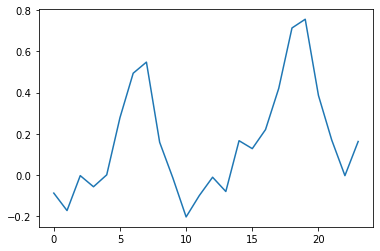

In [12]:
# plt.plot(X_train[-1:-1:].flatten())
plt.plot(y_train[-4:].flatten())

In [13]:
# from sklearn.model_selection import 

In [14]:
from torch.utils.data import Dataset, DataLoader
class DS(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        data = self.X_train[idx, :]
        labels = self.y_train[idx, :]
        return data, labels

In [15]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size=100):
        super().__init__()
        input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size*2, num_layers=1, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size*2, 1)
            
    def forward(self,x):

        # print(x.shape)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # print(x.shape)
        x = self.fc(x)
        
        # print(x.shape)
        return x

In [16]:
model = Model(input_size=len(train_cols))

In [17]:
db = DataBunch.create(DS(X_train, y_train), valid_ds=None, bs=8)

In [18]:
learn = Learner(db, model, loss_func=nn.MSELoss())
learn.callbacks.append(ShowGraph(learn))
learn.callbacks.append(CSVLogger(learn))
# learn.callbacks.append(SaveModelCallback(learn, name=f'model_fold_{index}'))

epoch,train_loss,valid_loss,time
0,0.221894,#na#,00:00
1,0.217944,#na#,00:00
2,0.229515,#na#,00:00
3,0.235612,#na#,00:00
4,0.232380,#na#,00:00
5,0.229479,#na#,00:00
6,0.233790,#na#,00:00
7,0.235407,#na#,00:00
8,0.239918,#na#,00:00
9,0.243205,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


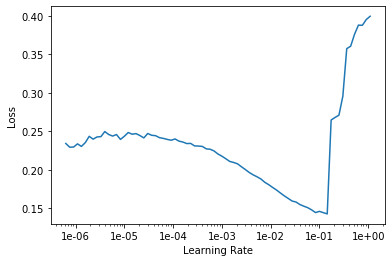

In [19]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.254625,0.216218,00:00
1,0.224760,0.196420,00:00
2,0.208139,0.175846,00:00
3,0.189978,0.153870,00:00
4,0.182326,0.130640,00:00
5,0.169393,0.111408,00:00
6,0.159944,0.109800,00:00
7,0.153933,0.126238,00:00
8,0.150547,0.108647,00:00
9,0.144266,0.083598,00:00


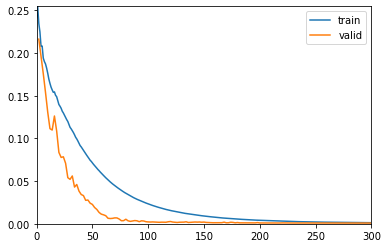

In [20]:
learn.fit_one_cycle(150, max_lr=1e-2)

In [21]:
fut_pred = 12
train_window = len(train_cols)
test_inputs = X_train[-1, -1, :].tolist()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:]).view(1, 1, -1)
    with torch.no_grad():
        yala = model(seq).item()
        test_inputs.append(model(seq).item())

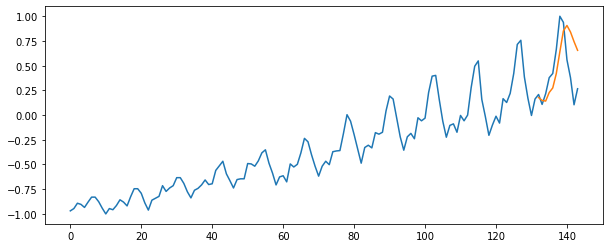

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(flight_data['passengers'])
plt.plot(np.arange(132, 144, 1), test_inputs[-fut_pred:])